In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score,calinski_harabasz_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [212]:
!unzip '/content/cs-training.csv.zip'

Archive:  /content/cs-training.csv.zip
replace cs-training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [236]:
df=pd.read_csv('/content/cs-training.csv')

In [237]:
df=df[:1000]

In [238]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [239]:
df.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [240]:
df.drop(columns=['Unnamed: 0','SeriousDlqin2yrs'],inplace=True)

In [241]:
df.duplicated().sum()

np.int64(0)

In [242]:
df.shape

(1000, 10)

In [243]:
df.drop_duplicates(inplace=True)

In [244]:
df.isna().sum()/df.shape[0]

,0
RevolvingUtilizationOfUnsecuredLines,0.000
age,0.000
NumberOfTime30-59DaysPastDueNotWorse,0.000
DebtRatio,0.000
MonthlyIncome,0.181
NumberOfOpenCreditLinesAndLoans,0.000
NumberOfTimes90DaysLate,0.000
NumberRealEstateLoansOrLines,0.000
NumberOfTime60-89DaysPastDueNotWorse,0.000
NumberOfDependents,0.033


In [245]:
df.dropna(subset=['NumberOfDependents'],inplace=True)
df.shape

(967, 10)

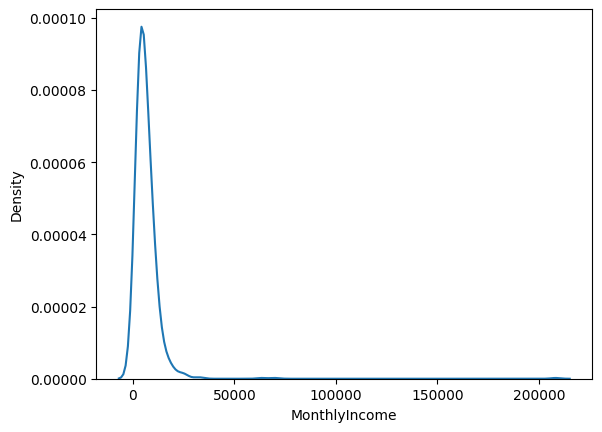

In [246]:
sns.kdeplot(df['MonthlyIncome'])
plt.show()

In [247]:
features_for_imputation=['age',
 'DebtRatio',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines']

In [248]:
df_nmi=df.drop(columns='MonthlyIncome')
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_nmi),
                           columns=df_nmi.columns)

In [249]:
dat=scaled_data[features_for_imputation]
dat['MonthlyIncome']=df['MonthlyIncome']
dat.isna().sum()

/tmp/ipython-input-599200698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['MonthlyIncome']=df['MonthlyIncome']


,0
age,0
DebtRatio,0
NumberOfOpenCreditLinesAndLoans,0
NumberRealEstateLoansOrLines,0
RevolvingUtilizationOfUnsecuredLines,0
MonthlyIncome,174


In [254]:
imputer = KNNImputer(n_neighbors=5)
imputed_scaled = pd.DataFrame(imputer.fit_transform(dat),
                              columns=dat.columns,index=dat.index)

In [255]:
dat.columns

Index(['age', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines',
       'MonthlyIncome'],
      dtype='object')

In [256]:
cols=[
       'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
        'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

In [260]:
imputed_scaled[cols]=scaled_data[cols]
imputed_scaled.isna().sum()

,0
age,0
DebtRatio,0
NumberOfOpenCreditLinesAndLoans,0
NumberRealEstateLoansOrLines,0
RevolvingUtilizationOfUnsecuredLines,0
MonthlyIncome,0
NumberOfTime30-59DaysPastDueNotWorse,0
NumberOfTimes90DaysLate,0
NumberOfTime60-89DaysPastDueNotWorse,0
NumberOfDependents,0


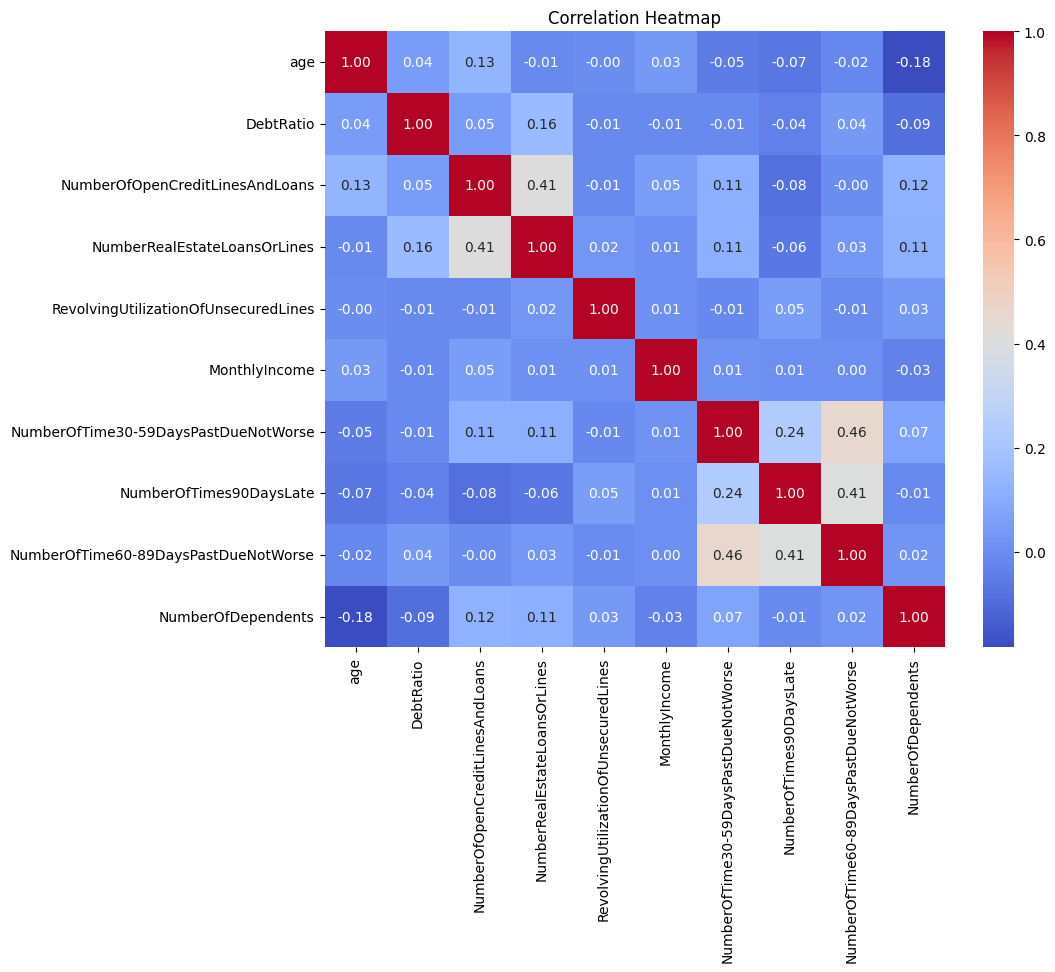

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = imputed_scaled.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [262]:
# Flatten the correlation matrix and filter high correlations
threshold = 0.8  # adjust threshold
high_corr = (
    corr_matrix.where(~np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
    .stack()
    .reset_index()
)
high_corr.columns = ["Feature1", "Feature2", "Correlation"]
high_corr = high_corr[high_corr["Correlation"].abs() > threshold]

print("Highly correlated pairs:")
print(high_corr)

Highly correlated pairs:
                                Feature1  \
0                                    age   
10                             DebtRatio   
19       NumberOfOpenCreditLinesAndLoans   
27          NumberRealEstateLoansOrLines   
34  RevolvingUtilizationOfUnsecuredLines   
40                         MonthlyIncome   
45  NumberOfTime30-59DaysPastDueNotWorse   
49               NumberOfTimes90DaysLate   
52  NumberOfTime60-89DaysPastDueNotWorse   
54                    NumberOfDependents   

                                Feature2  Correlation  
0                                    age          1.0  
10                             DebtRatio          1.0  
19       NumberOfOpenCreditLinesAndLoans          1.0  
27          NumberRealEstateLoansOrLines          1.0  
34  RevolvingUtilizationOfUnsecuredLines          1.0  
40                         MonthlyIncome          1.0  
45  NumberOfTime30-59DaysPastDueNotWorse          1.0  
49               NumberOfTimes90DaysLate  

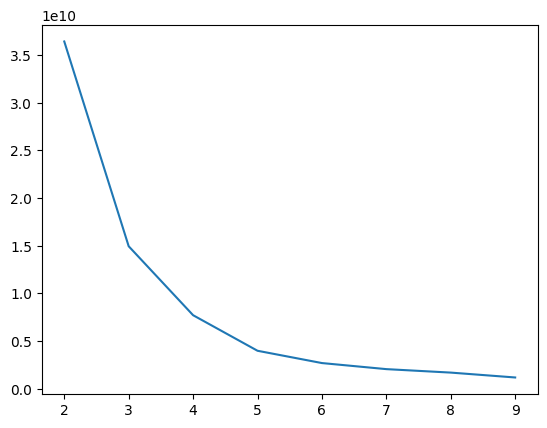

In [264]:
from sklearn.cluster import KMeans

# Decide number of clusters (try 2–10 and compare)
wcss=[]
sil=[]
for i in range(2,10):
  kmeans = KMeans(n_clusters=i, random_state=42)
  clusters=kmeans.fit_predict(imputed_scaled)
  sil.append(silhouette_score(imputed_scaled,clusters))
  wcss.append(kmeans.inertia_)
plt.plot(range(2,10),wcss)

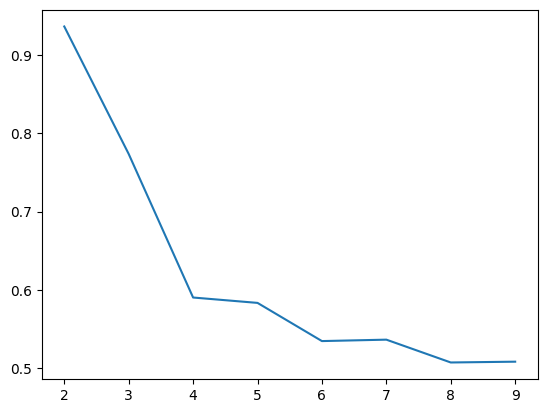

In [265]:
plt.plot(range(2,10),sil)

In [269]:
#choose with best wcss and silhouette score
k=3
kmeans=KMeans(n_clusters=k, random_state=42)
df['km_cluster']=kmeans.fit_predict(imputed_scaled)
imputed_scaled['km_cluster']=kmeans.fit_predict(imputed_scaled)

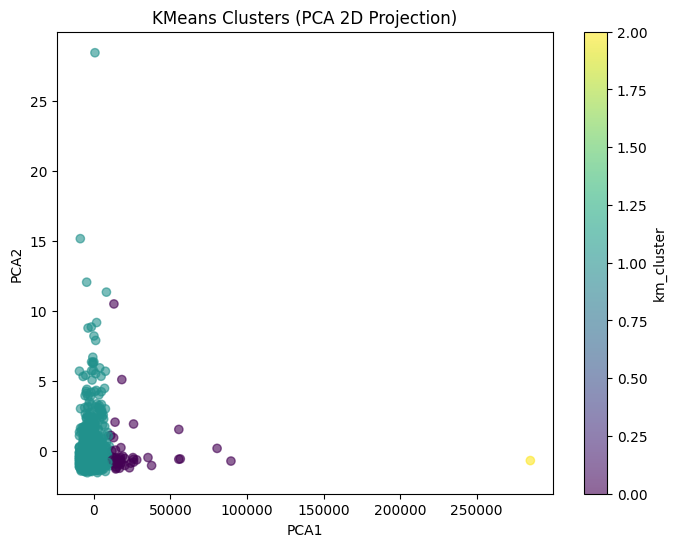

In [270]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(imputed_scaled.drop("km_cluster", axis=1))

imputed_scaled["PCA1"] = pca_result[:,0]
imputed_scaled["PCA2"] = pca_result[:,1]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(imputed_scaled["PCA1"], imputed_scaled["PCA2"],
            c=imputed_scaled["km_cluster"], cmap="viridis", alpha=0.6)

plt.title("KMeans Clusters (PCA 2D Projection)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(label="km_cluster")
plt.show()

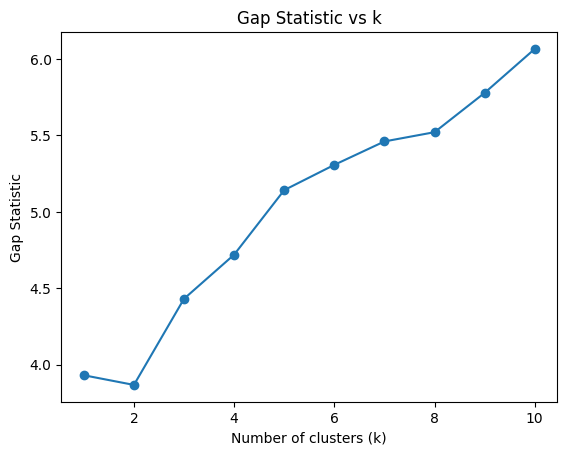

Best number of clusters by Gap Statistic: 1


In [271]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

def gap_score(data, labels, n_refs=10):
    """
    Compute Gap Statistic for a given clustering result.

    Parameters:
        data (array-like): data used for clustering (scaled)
        labels (array-like): cluster labels from your method
        n_refs (int): number of random reference datasets

    Returns:
        gap (float): Gap score for the clustering
    """
    data = np.array(data)
    labels = np.array(labels)
    k = len(np.unique(labels))

    # Within-cluster dispersion (Wk)
    disp = 0
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        if len(cluster_points) > 1:
            center = cluster_points.mean(axis=0)
            disp += ((cluster_points - center) ** 2).sum()
    log_wk = np.log(disp)

    # Reference dispersions
    ref_disps = []
    for _ in range(n_refs):
        random_data = np.random.uniform(low=np.min(data, axis=0),
                                        high=np.max(data, axis=0),
                                        size=data.shape)
        km = KMeans(n_clusters=k, random_state=42).fit(random_data)
        ref_disps.append(np.log(km.inertia_))

    gap = np.mean(ref_disps) - log_wk
    return gap

# Example usage
gap = gap_score(imputed_scaled, clusters, n_refs=10)
print("Gap Score for given clustering:", gap)